In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [36]:
data = np.array([
    120.5, 121.3, 122.1, 121.8, 122.9,
    124.0, 125.2, 126.1, 127.0, 128.4,
    129.1, 130.5, 131.2, 132.0, 133.6
], dtype=np.float32)

In [37]:
data_min = data.min()
data_max = data.max()
data_norm = (data - data_min) / (data_max - data_min)

In [38]:
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)
WINDOW_SIZE = 3
X, y = create_sequence(data_norm, WINDOW_SIZE)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  

In [39]:
class RNNForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNForecast, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        final_hidden = out[:, -1, :]
        return self.fc(final_hidden)

In [40]:
INPUT_SIZE = 1
HIDDEN_SIZE = 32
OUTPUT_SIZE = 1
LR = 0.001
EPOCHS = 500
model = RNNForecast(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [41]:
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.6f}")

Epoch [100/500], Loss: 0.001108
Epoch [200/500], Loss: 0.001062
Epoch [300/500], Loss: 0.001052
Epoch [400/500], Loss: 0.001041
Epoch [500/500], Loss: 0.001029


In [42]:
model.eval()
with torch.no_grad():
    predicted_norm = model(X).numpy()
    actual_norm = y.numpy()
predicted = predicted_norm * (data_max - data_min) + data_min
actual = actual_norm * (data_max - data_min) + data_min

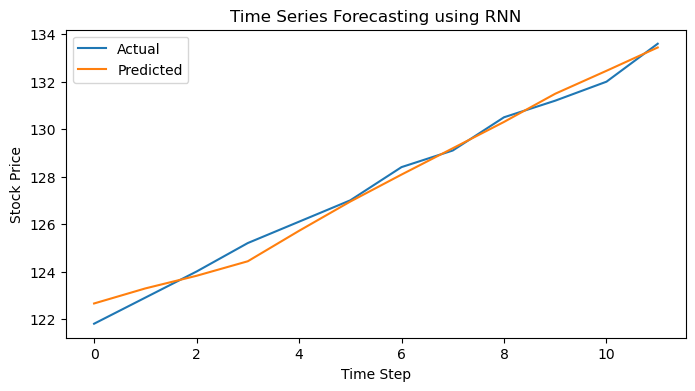

In [43]:
plt.figure(figsize=(8,4))
plt.plot(actual.flatten(), label="Actual")
plt.plot(predicted.flatten(), label="Predicted")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.title("Time Series Forecasting using RNN")
plt.legend()
plt.show()

In [44]:
def predict_next(model, input_seq):
    model.eval()
    with torch.no_grad():
        input_seq = np.array(input_seq, dtype=np.float32)
        input_seq_norm = (input_seq - data_min) / (data_max - data_min)
        input_seq_norm = torch.tensor(input_seq_norm).unsqueeze(0).unsqueeze(-1)
        prediction_norm = model(input_seq_norm).item()
        prediction = prediction_norm * (data_max - data_min) + data_min
    return prediction


In [45]:
test_input = [120.5, 121.3, 122.1]
next_value = predict_next(model, test_input)
print("Input:", test_input)
print("Predicted Output:", round(next_value, 2))


Input: [120.5, 121.3, 122.1]
Predicted Output: 122.65
